# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

**Задача 1. Сходимость kmeans.**

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



Мы минимизируем функционал $\sum_{n=1}^N\sum_{k=1}^K r_{n, k}||x_{n} - \mu_{k}||$.

На первом шаге минимизируем по $r_{n,k}$(выбираем $argmin_{k=1,\dots,K}(||x_{n} - \mu_{k}||)$ и на этом месте ставим единицу, а на остальных 0).

На втором шаге минимизируем по $\mu_{k}$ когда берём $\mu_k^{new} = \frac{\sum_{n}r_{n,k}x_{n}}{\sum_{n}r_{n,k}}$ Очевидно, что функционал уменьшается, т.к. центр масс.

Наш функционал как минимум >= 0 и каждый раз он уменьшается. По теореме Вейерштрасса есть сходимость

Докажем, что сходимость меньше, чем $K^{N}$:

Очевидно, что это полный перебор. Если было бы долше, то алгоритма бы не было ч.т.д.

А если серьёзно, то если каждый раз $\mu_{k+1} \neq \mu_{k}$, то мы должны пробежать $K^{N}$ вариантов соответственно мы вернемся к первому значению функционала(всё время не возрастали, а тут вернулись в какое-то значение функционала, когда такое возможно? когда все значения функционала равны). Получили противоречие

**Задача 2.  ММП для многомерного нормального распределения.**

Функция правдоподобия в общем случае записывается как
$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$

$$\sum_{i=1}^{L}\ln(\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}) \rightarrow \min$$

$$(\sum_{i=1}^L-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu))'_{\mu} = 0$$

$$\sum_{i=1}^L-\Sigma^{-1}x_{i} - (x_{i}^T\Sigma^{-1})^T + \Sigma^{-1}\mu + (\mu^T\Sigma^{-1})^T = 0$$

$$\sum_{i=1}^L-\Sigma^{-1}x_{i} - (\Sigma^{-1})^T x_{i} + \Sigma^{-1}\mu + (\Sigma^{-1})^T\mu = 0$$

$$L(\Sigma^{-1} + (\Sigma^{-1})^T)\mu = (\Sigma^{-1} + (\Sigma^{-1})^T)\sum_{i=1}^{L}x_{i}$$

$$\mu = \frac{\sum_{i=1}^{L}x_{i}}{L}$$

обратная существует т.к. $$(A + A^T)^{-1} = \frac{A^{-1}}{2}$$

**Задача 3. Формулы Ланса-Вильямса.**

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




**1-ая формула**

Очевидно, что можно выделить всего три точки(A B C), из U, V и S для которых достигается минимум расстояний между US и VS. Тогда $d_{\min}(U \cup V, S)$ достигается либо на A либо на B. Очевидно, что формула будет верна

$\frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S)| = \frac{Min}{2} + \frac{Max}{2} - \frac{Max-Min}{2} = Min$

где $Min $ и $ Max$ это минимальное и максимальное расстояние из минимумов расстояний между парами множеств

**2-ая формула**

Аналогично можно выделить три точки (A, B, C) на которых достигается $d_{\max}(U \cup V, S) $, $d_{\max}(U, S)$, $d_{\max}(V, S)$

первый максимум доастигается на одной из двух точек в которых достигается максимум 2 и 3

$\frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) | = \frac{Min}{2} + \frac{Max}{2} + \frac{Max-Min}{2} = Max$

где $Min $ и $ Max$ это минимальное и максимальное расстояние из максимумов расстояний между парами множеств

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
import sklearn
from scipy.spatial import distance as dist_sci
from scipy.cluster.hierarchy import dendrogram

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    
    
    def __init__(self, metric, **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        if metric is  None:
            metric = "euclidian"
        
        
        distance = None
        num_clusters = None
        for key, value in kwargs.items():
            
            if key == "distance":
                distance = value
                
            if key == "num_clusters":
                num_clusters = value
                
            
        if distance is None:
            distance = "single"
            
        if num_clusters is None:
            num_clusters = 5
            
         
        
        self.num_clusters = num_clusters
        
        
        if distance == "single":
            
            self.distance = self.single
            
        elif distance == "complete":
            self.distance = self.complete
        
        elif distance == "average":
            self.distance = self.average
        else:
            raise 
        
        
        
        if metric == "euclidian":
            self.metric = metric
            
        elif metric == "cosine":
            self.metric = metric 
            
        else:
            raise
        
    def single(self, x):
        return x.min()
        
    
    def complete(self, x):
        return x.max()
    
    def average(self, x):
        return x.mean()
        
    def fit_predict(self, X):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        X = np.array(X)
        
        self.tree = []
        self.merge = []
        self.tree = np.array([i for i in range(X.shape[0])])
        cnt = X.shape[0]
        
        num_clusters = X.shape[0]
        preds = 0
        
        self.distances = sklearn.metrics.pairwise_distances(X, X, metric=self.metric)
        self.dendro = []
        
        while num_clusters > 1:
            clusters = np.unique(self.tree)
            Min = -1
            I = 0
            J = 0
            numbers_on_top = self.tree
            
            
            for i in range(clusters.shape[0]):
                for j in range(i + 1, clusters.shape[0]):
                    a = numbers_on_top == clusters[i]
                    b = numbers_on_top == clusters[j]
                    
                    dis = self.distances[a][:,b]
                    dis = self.distance(dis)
                    if Min == -1:
                        Min = dis
                        I = clusters[i]
                        J = clusters[j]
                    elif Min > dis:
                        Min = dis
                        I = clusters[i]
                        J = clusters[j]
            
            
            a = self.tree
            
            self.tree = np.where((a != I) &( a != J), a, cnt)[:] 
            a = self.tree
            self.dendro.append([I, J, Min, a[a==cnt].shape[0]])
            cnt+=1
            if num_clusters -1 == self.num_clusters:
                
                preds = self.tree
                
                uni = np.unique(preds)
                
                for i in range(uni.shape[0]):
                    preds = np.where(preds != uni[i],preds, i)
                
            num_clusters-=1
            a = self.tree
            
            
        
        return preds
    
    def plot_dendrogram(self,labels):
        """
        Try to visualize our data
        """
        
        return dendrogram(np.array(self.dendro).astype(float), 
                                                  labels=labels, 
                                                  leaf_rotation=True,
                                                  leaf_font_size=10)
        

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

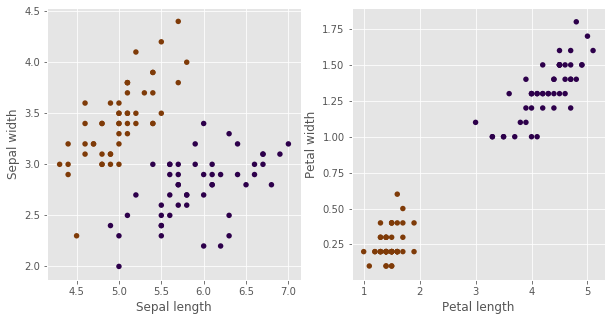

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [4]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0014133453369140625


In [5]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
custum_aggl = Clustering(metric='cosine', num_clusters=2)
aggl_t0 = time.time()
aggl_pred = custum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))


Our AGGL score 1.0. Our AGGL time 1.5491538047790527


# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

**Ответы**

1) Можно. Если в самом начале(последние объединения) единичные вершины или очень маленькие кластеры присоединяются к большим

2) Лучше всего использовать косинусовое расстояние

3) 0.69

4) Можно результат кластеризации закинуть в качестве фичи к матрице (она очень хорошо коррелирует с вектором ответов в случае задачи классификации)

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN
from pymystem3 import Mystem
from nltk.corpus import stopwords
import scipy

**У меня уже есть предобработанные заголовки, воспользуюсь ими**

In [95]:
data = pd.read_csv("TitlesTrain.csv")

y_train = np.array(data["target"])
groups_train = np.array(data["group"])
texts = np.array(data["information"])

In [96]:
table.head()

,doc_id,title,group_id,target
0,15731,ваз замена подшипник ступица нива\n,1,0
1,14829,ваз опт сочи сравнивать цена купить по...,1,0
2,15764,купить ступица лад калина трансмиссия пере...,1,0
3,17669,классика \n,1,0
4,14852,ступица нива замена подшипник свой рука\n,1,0


In [97]:

for i in range(len(texts)):
    if texts[i] is  np.nan:
        texts[i] = ""
    

In [98]:
texts

array(['ваз 21213   замена подшипник ступица   нива \n',
       ' ваз 2107 опт  сочи  сравнивать цена  купить потребительский товар  tiu  \n',
       'купить ступица лад калина2  трансмиссия   переходный ступица цена  замена  тюнинг  \n',
       ..., 'jizolofej  archive \n',
       ' звать парень диана шурыгина   пусть говорить  диана шурыгина \n',
       'культура   шоубиз    визит  ревизорро   смоленск обертываться драка  распыление газ    сми express \n'],
      dtype=object)

In [100]:
clf = TfidfVectorizer()
X_train = clf.fit_transform(texts)
X_train = X_train.todense()


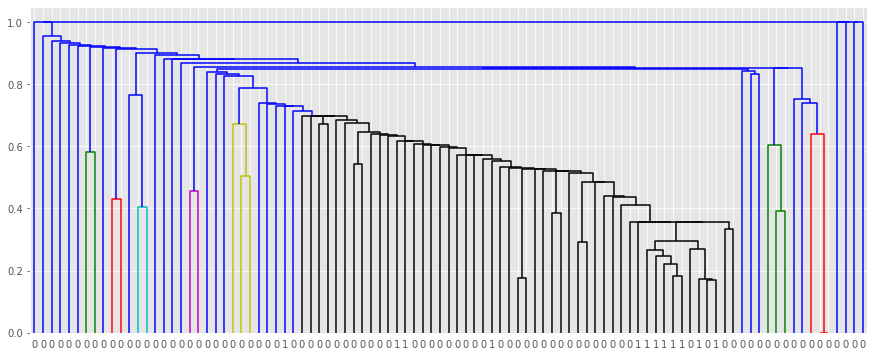

In [102]:
X = X_train[groups == 10]
y = y_train[groups == 10]
#     print(X.shape)
alg = Clustering(metric="cosine", n_clusters=2, distance="single")

alg.fit_predict(X)
fig, axes = plt.subplots(1, figsize=(15, 6))
alg.plot_dendrogram(y)
plt.show()


**Эта дендрограмма, как и многие другие показывает, что в наших данных очень много шума. Невыбросы в начале довольно хорошо кластеризуется**

In [103]:
# X = data[new_groups == 2]
# y = new_target[new_groups == 2]
# #     print(X.shape)
# num = int(y.shape[0] * 0.75)
# alg = Clustering(metric="cosine", num_clusters=num, distance="single")

# res = alg.fit_predict(X)
# uniq, cnt = np.unique(res, return_counts=True)
# print(res)
# Max = uniq[cnt.argmax()]
# for i in range(res.shape[0]):
#     if res[i] == Max:
#         res[i] = 1
#     else:
#         res[i] = 0
# f1_score(res, y)


In [134]:
mean_f1 = 0
final_res = []
for i1 in range(1, 130):
    X = X_train[groups_train == i1]
    y = y_train[groups_train == i1]
    #     print(X.shape)
    num = int(y.shape[0] * 0.6)
    alg = Clustering(metric="cosine", num_clusters=num, distance="single")

    res = alg.fit_predict(X)
    
    uniq, cnt = np.unique(res, return_counts=True)

    Max = np.partition(res, 2)[-2:]
    for i in range(res.shape[0]):
        if res[i] in Max:
            res[i] = 1
        else:
            res[i] = 0
    mean_f1 += f1_score(y,res)
    print(f1_score(y, res))
    final_res += list(res)
    
print(mean_f1 / 129)
    
    

0.33333333333333337
0.0
0.0
0.43750000000000006
0.0
0.5428571428571429
0.0
0.07142857142857144
0.35714285714285715
0.3673469387755102
0.3684210526315789
0.4799999999999999
0.25
0.5555555555555556
0.0
0.0
0.05333333333333332
0.5238095238095238
0.7000000000000001
0.0
0.33333333333333337
0.5523809523809524
0.5121951219512195
0.6516853932584269
0.23809523809523808
0.5769230769230769
0.0
0.0
0.0
0.0
0.0
0.0
0.5573770491803279
0.5287356321839082
0.0
0.0
0.2857142857142857
0.0
0.0
0.0
0.0
0.0
0.3243243243243243
0.0
0.4918032786885246
0.0
0.4878048780487805
0.45454545454545453
0.0625
0.5614035087719299
0.2631578947368421
0.5849056603773585
0.43478260869565216
0.0
0.4
0.0
0.6486486486486487
0.0
0.0
0.6138613861386139
0.41379310344827586
0.0
0.0
0.3829787234042553
0.0
0.0
0.65
0.0
0.5849056603773585
0.0
0.0
0.0
0.0
0.0
0.375
0.3125
0.06000000000000001
0.37837837837837834
0.0
0.6461538461538462
0.0909090909090909
0.3125
0.12903225806451613
0.3846153846153846
0.4615384615384615
0.14492753623188404

In [135]:
f1_score(target,final_res)

0.245125348189415

В выделении кластеров с помощью аггломеративной кластеризации я пытался подобрать число кластеров так, чтобы образовались кластеры с невыбросами и при этом, чтобы они имели наибольшой размер среди образовавшихся кластеров. В некоторых группах всё было норм, а в некоторых совсем плохо. Финальный скор очень плох.

In [117]:
res1 = []
for i in np.unique(groups_train):
    X_ = X_train[groups_train == i]

    clf = DBSCAN(0.495, metric="cosine", min_samples=7)
    res = clf.fit_predict(X_)


    for j in range(len(res)):
        if res[j] == -1:
            res[j] = 0
        else:
            res[j] = 1
        res1.append(res[j])

corr = np.corrcoef(y_train, res1)[0,1]
print(corr, f1_score(res1, data["target"]))

0.5927695026991388 0.6989453499520614


**С помощью агломеративной кластеризации и кластеризации невыбросов ничего путного получить не удалось. А вот используя DBSCAN и кластеризации выбросов, подобрав параметры удалось получить точность 0.69 на трейне (на тесте тоже что-то около того)**

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [11]:
# Место для Вашего кластерного анализа


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***